<H1 style="text-align: center;">Hypoglycemia Detection</H1>
<H3 style="text-align: center;">Inferential Statistics</H3>
###Imports

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime
import seaborn as sns
import copy

###Get Cleaned Data From The Files

In [57]:
df = pd.DataFrame([]) # defining a dataframe
df = pd.read_csv('../Data/Cleaned/data.csv')

df['Code'] = df['Code'].astype('category')

df['Date_Time'] = pd.to_datetime(df['Date_Time'].str.strip(), 
                                 format="%Y-%m-%d %H:%M:%S", errors="raise")

df.head()

,Code,Blood_Glucose,Patient_ID,Code_Description,Date_Time
0,58,101.0,31,PRE_BREAKFAST,1991-05-20 08:00:00
1,33,5.0,31,REGULAR_INSULIN_DOSE,1991-05-20 12:00:00
2,34,27.0,31,NPH_INSULIN_DOSE,1991-05-20 08:00:00
3,60,89.0,31,PRE_LUNCH,1991-05-20 12:00:00
4,33,3.0,31,REGULAR_INSULIN_DOSE,1991-05-20 12:00:00


###Create aggregated dataframe containing various suspected fields that cause hypoglycemic symptoms. We got these fields from EDA

In [59]:
group_df = df.groupby('Patient_ID')

df_agg = pd.DataFrame({
    'median' : group_df['Blood_Glucose'].mean(),
    'std' : group_df['Blood_Glucose'].std(),
    'highs_perday' : group_df.apply(lambda group : group[group['Blood_Glucose']>200]['Blood_Glucose'].count()
                                    /(group.Date_Time.max() - group.Date_Time.min()).days),
    'hypos_perday' : group_df.apply(
        lambda group : group[group['Code_Description']=='HYPOGLYCEMIC_SYMPTOMS']['Code_Description'].count()
        /((group.Date_Time.max() - group.Date_Time.min()).days)),
    'exercise_perday' : group_df.apply(
        lambda group : group[(group['Code_Description']=='TYPICAL_EXERCISE') |
                            (group['Code_Description']=='LESS_EXERCISE') |
                            (group['Code_Description']=='MORE_EXERCISE')]['Code_Description'].count()
        /((group.Date_Time.max() - group.Date_Time.min()).days)),
    'irregular_diet_perday' : group_df.apply(
        lambda group : group[(group['Code_Description']=='MORE_MEAL_INJESTION') |
                            (group['Code_Description']=='LESS_MEAL_INJESTION')]['Code_Description'].count()
        /((group.Date_Time.max() - group.Date_Time.min()).days)),
    'irregular_exercise_perday' : group_df.apply(
        lambda group : group[(group['Code_Description']=='LESS_EXERCISE') |
                            (group['Code_Description']=='MORE_EXERCISE')]['Code_Description'].count()
        /((group.Date_Time.max() - group.Date_Time.min()).days)),
    'readings_perday' : group_df['Date_Time'].apply(lambda group : group.count()
                                                /((group.max() - group.min()).days)),
    'snacks_perday' : group_df.apply(lambda group : group[group['Code_Description']=='PRE_SNACK']['Code_Description'].count()
                                    /(group.Date_Time.max() - group.Date_Time.min()).days),
    'regular_insulin_perday' : group_df.apply(lambda group : group[group['Code_Description']=='REGULAR_INSULIN_DOSE']['Code_Description'].count()
                                    /(group.Date_Time.max() - group.Date_Time.min()).days),
    'nph_insulin_perday' : group_df.apply(lambda group : group[group['Code_Description']=='NPH_INSULIN_DOSE']['Code_Description'].count()
                                    /(group.Date_Time.max() - group.Date_Time.min()).days),
    'ultralente_insulin_perday' : group_df.apply(lambda group : group[group['Code_Description']=='ULTRALENTE_INSULIN_DOSE']['Code_Description'].count()
                                    /(group.Date_Time.max() - group.Date_Time.min()).days),
    'insulin_perday' : group_df.apply(
        lambda group : group[(group['Code_Description']=='REGULAR_INSULIN_DOSE') |
                            (group['Code_Description']=='NPH_INSULIN_DOSE') |
                            (group['Code_Description']=='ULTRALENTE_INSULIN_DOSE')]['Code_Description'].count()
        /((group.Date_Time.max() - group.Date_Time.min()).days)),
    'postmeal_median_bg': group_df.apply(
        lambda group : group[(group['Code_Description']=='POST_LUNCH')]['Blood_Glucose'].median())
})

df_agg.loc[df_agg['postmeal_median_bg'].isnull(), 'postmeal_median_bg'] = df_agg.loc[df_agg['postmeal_median_bg'].isnull(), 'median']

df_agg.head()

,exercise_perday,highs_perday,hypos_perday,insulin_perday,irregular_diet_perday,irregular_exercise_perday,median,nph_insulin_perday,postmeal_median_bg,readings_perday,regular_insulin_perday,snacks_perday,std,ultralente_insulin_perday
Patient_ID,,,,,,,,,,,,,,
1,0.0,0.762963,0.362963,3.674074,0.000000,0.0,67.783333,0.970370,67.783333,6.666667,2.703704,0.000000,85.840507,0.000000
2,0.0,1.715789,0.000000,3.926316,0.000000,0.0,100.045205,0.021053,100.045205,7.684211,3.905263,0.000000,105.922854,0.000000
3,0.0,0.657895,0.078947,3.421053,0.263158,0.0,70.313793,0.026316,178.000000,7.631579,1.552632,0.394737,80.270788,1.842105
4,0.0,1.131579,0.026316,3.684211,0.157895,0.0,82.479310,1.421053,187.500000,7.631579,1.789474,0.842105,96.339767,0.473684
5,0.0,1.100000,0.000000,3.600000,0.050000,0.0,85.882759,1.875000,166.000000,7.250000,1.725000,0.900000,98.199818,0.000000


###Below is the heat map of correlation matrix of all the suspected fields for the whole population

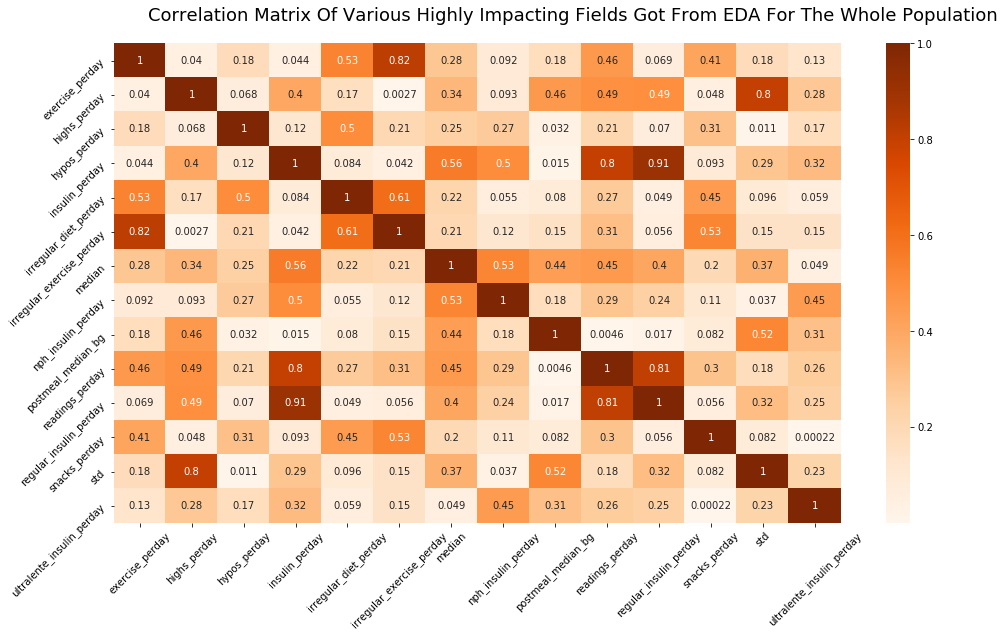

In [63]:

fig = plt.gcf()
fig.suptitle('Correlation Matrix Of Various Highly Impacting Fields Got From EDA For The Whole Population', 
             fontsize=18, horizontalalignment = 'center')
fig.set_size_inches(16, 10, forward=True)
corr = np.absolute(df_agg.corr())
plt.yticks(rotation=45) 
plt.xticks(rotation=45)
sns.heatmap(corr, annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, cmap='Oranges', cbar_kws={"orientation": "vertical"})

plt.yticks(rotation=45) 
plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0.1, 0.9, 0.95])
plt.show()

###Below is the list of correlation values in descending order for the whole population

In [64]:
corr.sort_values(by='hypos_perday', ascending=False).hypos_perday

hypos_perday                 1.000000
irregular_diet_perday        0.503643
snacks_perday                0.311985
nph_insulin_perday           0.268673
median                       0.249250
readings_perday              0.214146
irregular_exercise_perday    0.205677
exercise_perday              0.180847
ultralente_insulin_perday    0.174110
insulin_perday               0.117071
regular_insulin_perday       0.069593
highs_perday                 0.068074
postmeal_median_bg           0.032225
std                          0.011175
Name: hypos_perday, dtype: float64

###Below is the heat map of correlation matrix of all the suspected fields for the hypoglycemic population

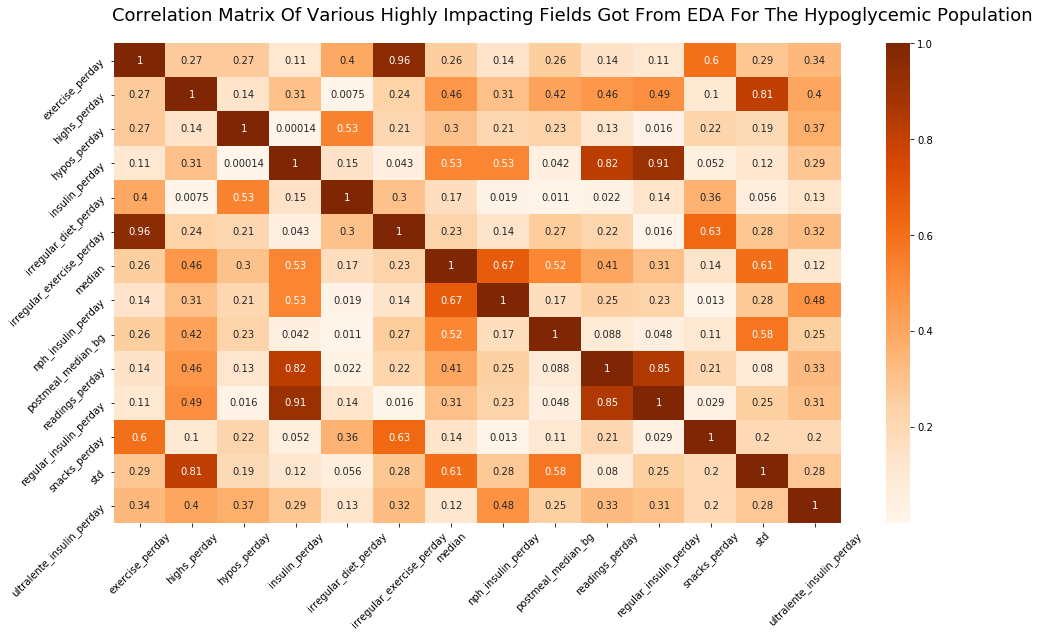

In [65]:
fig = plt.gcf()
fig.suptitle('Correlation Matrix Of Various Highly Impacting Fields Got From EDA For The Hypoglycemic Population', 
             fontsize=18, horizontalalignment = 'center')
fig.set_size_inches(16, 10, forward=True)
corr = np.absolute(df_agg[df_agg['hypos_perday']>0.0].corr())
plt.yticks(rotation=45) 
plt.xticks(rotation=45)
sns.heatmap(corr, annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, cmap='Oranges', cbar_kws={"orientation": "vertical"})

plt.yticks(rotation=45) 
plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0.1, 0.9, 0.95])
plt.show()

###Below is the list of correlation values in descending order for the hypoglycemic population

In [66]:
corr.sort_values(by='hypos_perday', ascending=False).hypos_perday

hypos_perday                 1.000000
irregular_diet_perday        0.532303
ultralente_insulin_perday    0.373580
median                       0.301466
exercise_perday              0.266994
postmeal_median_bg           0.231442
snacks_perday                0.219801
nph_insulin_perday           0.210841
irregular_exercise_perday    0.207763
std                          0.193489
highs_perday                 0.140469
readings_perday              0.127507
regular_insulin_perday       0.016155
insulin_perday               0.000141
Name: hypos_perday, dtype: float64

<H3 style="text-align: center;">Conclusion</H3>
<BR>
Now we know the parameters that are prime suspects of hypoglycemia. We are good to move on to create machine learning models.